In [1]:
!pip install gensim==3.8.3

In [2]:
!pip install wikipedia

In [43]:
import sys
import os
import itertools as it
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import decomposition as skd
from sklearn import feature_extraction as skfe
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import wikipedia
import difflib
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

wikipedia.set_lang('en')



#### Load tweet data files and extract hashtags

In [5]:
src_dir = r'C:\Users\elizabeth\Documents\cleaned tweets\cyber friends tweets'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))] # build list of files to iterate through

hashtags = pd.DataFrame()

with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        hashtags = pd.concat([hashtags, df[['hashtags']]], axis=0)
        pbar.update(1)

Files: 100%|███████████████████████████████████████████████████████████████████████████| 40/40 [01:55<00:00,  2.88s/it]


In [6]:
hashtags = hashtags[hashtags.astype(str)['hashtags'] != '[]'] # remove empties
hashtags

,hashtags
1,"['breaking', 'fbi', 'beirut', 'probe']"
2,"['breaking', 'beirutblast']"
6,['beirutblast']
9,"['breaking', 'lebanon']"
12,['lebanon']
...,...
87365,"['trust', 'technology']"
87379,['cogx2020']
87437,"['covid19uk', 'contacttracing']"
87439,['ai']


#### Build flat list of all hashtags

In [7]:
hlist = [] 
for hashtag in hashtags['hashtags']:
    hlist.extend(eval(hashtag))

#### Count frequency of each hashtag and sort the list in descending order

In [8]:
counted = Counter(hlist)
tf = sorted(dict(counted).items(), key=lambda x: x[1], reverse=True) # Sort hashtags by frequency in descending order
print(tf[:25])

[('covid19', 26035), ('ai', 15103), ('cybersecurity', 14355), ('fintech', 13138), ('coronavirus', 12274), ('infosec', 5539), ('tech', 4864), ('security', 4073), ('machinelearning', 3884), ('iot', 3795), ('technology', 3744), ('innovation', 3694), ('blockchain', 3493), ('london', 3316), ('brexit', 3216), ('data', 3044), ('banking', 3043), ('payments', 2997), ('privacy', 2992), ('covid', 2819), ('blacklivesmatter', 2771), ('china', 2738), ('artificialintelligence', 2643), ('startup', 2599), ('bitcoin', 2584)]


#### For initial investigation, select only hashtags used more than 1000 times

In [9]:
use_threshold = 1000
tf_popular = []
print('Length before: '+str(len(tf)))
for tag in tf:
    if  tag[1] >= use_threshold:
        tf_popular.append(tag)
print('Length after: '+str(len(tf_popular)))

Length before: 217569
Length after: 97


#### Build a matrix of concurrent use of hashtags, correlate and visualise

In [10]:
popular_hashtags = [item[0] for item in tf_popular]
hashtag_matrix = pd.DataFrame(0, index=popular_hashtags, columns=popular_hashtags).astype(int)

for item in hashtags['hashtags'].values:
    hashtag_list = eval(item)
    for a, b in it.permutations(hashtag_list, 2):
        if all([hashtag in popular_hashtags for hashtag in [a,b]]):
            hashtag_matrix.at[a, b] += 1
            
hashtag_matrix

,covid19,ai,cybersecurity,fintech,coronavirus,infosec,tech,security,machinelearning,iot,...,oott,cryptocurrency,compliance,mondaymotivation,economy,dataprotection,healthcare,socialmedia,facebook,news
covid19,220,296,578,439,2187,102,125,227,28,212,...,37,8,208,16,108,40,101,16,9,25
ai,296,450,671,1091,60,338,961,267,2218,1366,...,1,42,25,2,17,147,209,32,22,112
cybersecurity,578,671,140,211,309,2783,464,1222,106,817,...,3,32,222,6,3,263,122,26,26,69
fintech,439,1091,211,302,115,55,494,59,191,244,...,1,157,245,3,27,18,30,34,20,21
coronavirus,2187,60,309,115,56,40,52,167,3,151,...,13,7,195,9,77,19,19,8,9,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dataprotection,40,147,263,18,19,179,119,163,2,134,...,0,2,24,0,0,12,1,4,9,3
healthcare,101,209,122,30,19,30,37,40,34,76,...,0,0,4,0,3,1,10,2,1,9
socialmedia,16,32,26,34,8,7,32,10,6,25,...,0,2,1,18,0,4,2,2,52,10
facebook,9,22,26,20,9,16,23,14,8,2,...,0,13,0,0,0,9,1,52,2,5


In [11]:
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

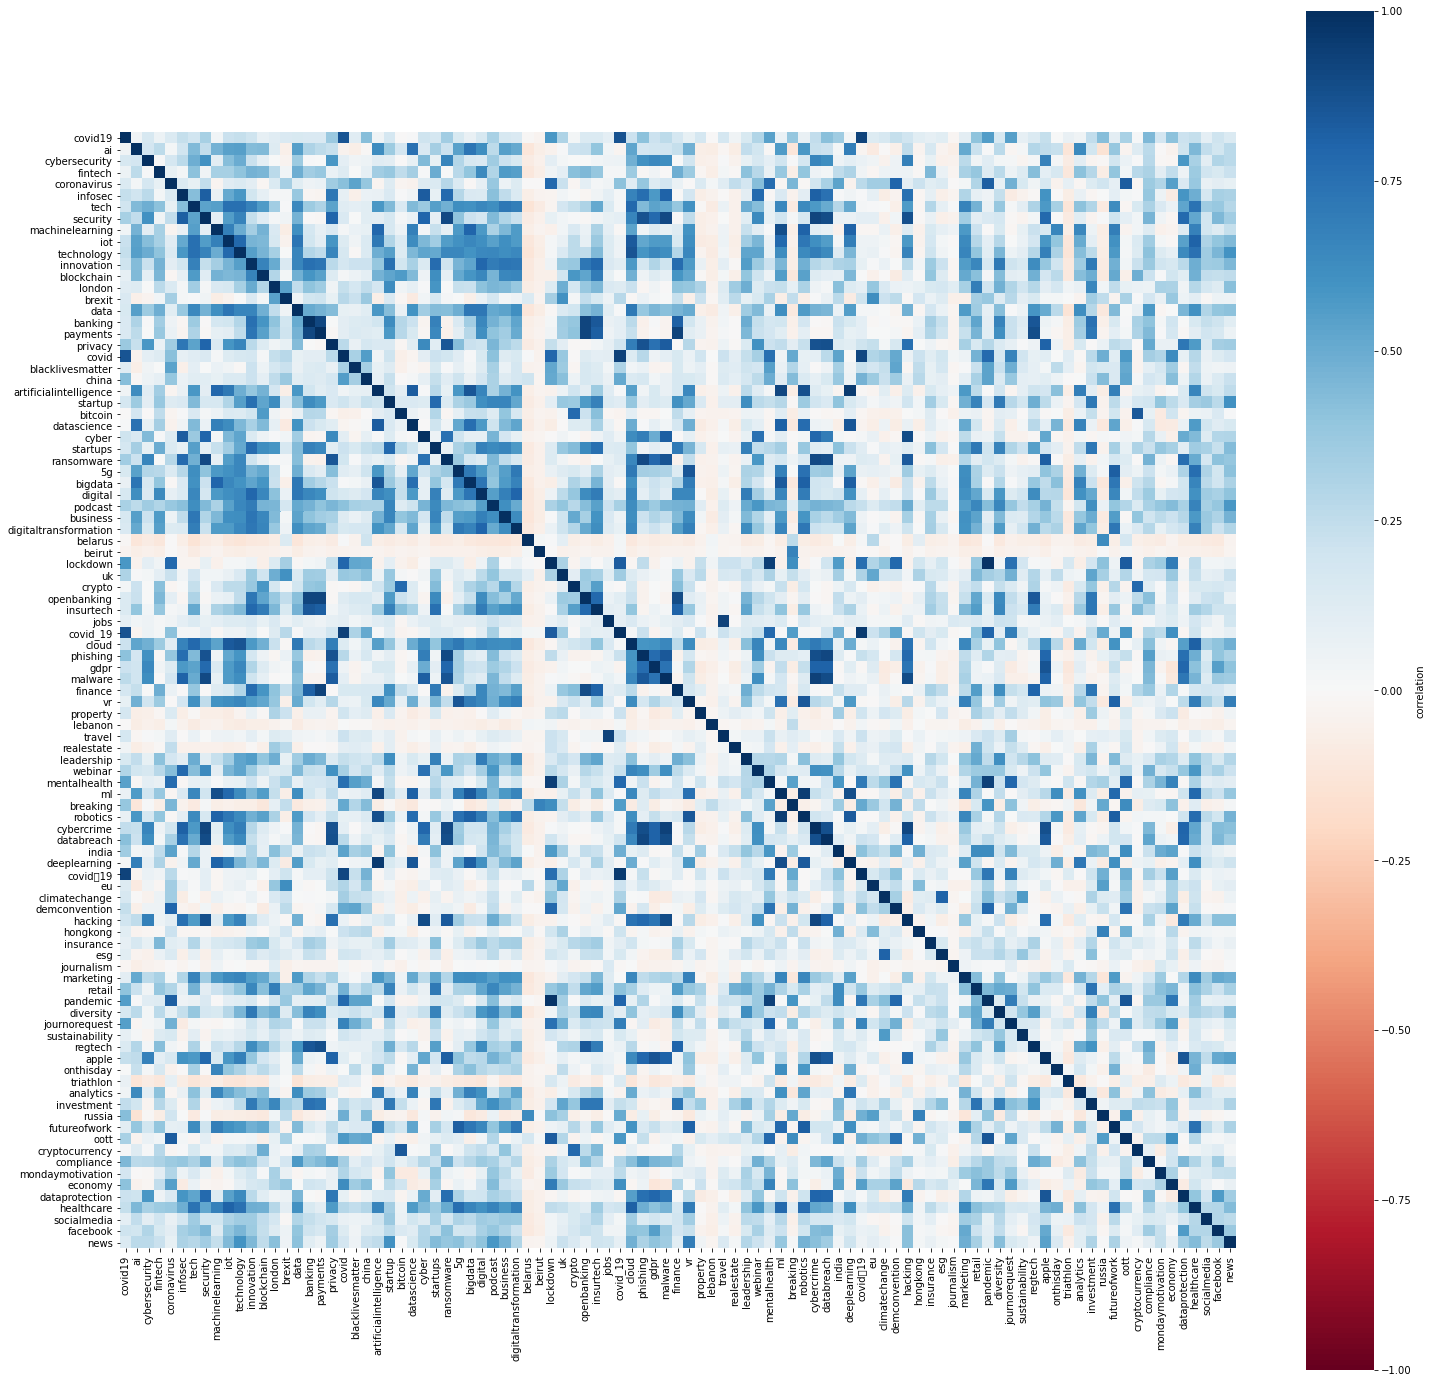

In [31]:
# plot the correlation matrix
plt.figure(figsize=(25, 25))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

In [13]:
correlations

,covid19,ai,cybersecurity,fintech,coronavirus,infosec,tech,security,machinelearning,iot,...,oott,cryptocurrency,compliance,mondaymotivation,economy,dataprotection,healthcare,socialmedia,facebook,news
covid19,1.000000,0.045160,0.166944,0.060142,0.146485,0.238178,0.195361,0.330684,0.034961,0.225904,...,0.321637,0.008977,0.449356,0.183172,0.406365,0.214350,0.240846,0.095822,0.205129,0.145965
ai,0.045160,1.000000,0.182521,0.262169,0.029530,0.196497,0.442430,0.246388,0.475178,0.544570,...,-0.035534,0.125860,0.265846,-0.003425,-0.039822,0.205777,0.446029,0.244219,0.192878,0.271838
cybersecurity,0.166944,0.182521,1.000000,0.009075,0.179100,0.272047,0.487787,0.603506,0.103781,0.425845,...,0.069627,0.013882,0.278252,-0.011891,-0.019818,0.583370,0.320464,0.105150,0.299062,0.267354
fintech,0.060142,0.262169,0.009075,1.000000,0.081598,0.025350,0.411080,0.039758,0.330631,0.332722,...,0.036179,0.273790,0.319117,0.107324,0.248401,0.054535,0.363348,0.201336,0.156901,0.226077
coronavirus,0.146485,0.029530,0.179100,0.081598,1.000000,0.143272,0.084523,0.249309,-0.030714,0.124514,...,0.831631,-0.022576,0.363729,0.301623,0.553412,0.149142,0.377609,0.073007,0.106836,0.085569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dataprotection,0.214350,0.205777,0.583370,0.054535,0.149142,0.592781,0.527292,0.780326,0.129107,0.542447,...,-0.006450,-0.013023,0.451305,-0.010912,-0.084284,1.000000,0.396331,0.186177,0.565669,0.351438
healthcare,0.240846,0.446029,0.320464,0.363348,0.377609,0.490126,0.736598,0.519021,0.674625,0.810594,...,0.286942,0.043327,0.300958,0.137849,0.193687,0.396331,1.000000,0.287328,0.292110,0.430036
socialmedia,0.095822,0.244219,0.105150,0.201336,0.073007,0.174452,0.354846,0.192766,0.193704,0.310526,...,0.038438,0.084395,0.162845,0.147987,0.074419,0.186177,0.287328,1.000000,0.294840,0.261825
facebook,0.205129,0.192878,0.299062,0.156901,0.106836,0.330583,0.376599,0.446493,0.125335,0.398135,...,0.021096,0.122765,0.357148,0.234333,0.013551,0.565669,0.292110,0.294840,1.000000,0.367762


#### Inspect a ranked list of correlated pairs of hashtags

In [14]:
s = correlations.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

In [15]:
so[97:200:2] # There are 97 hashtags in the popular list, so the first 97 entries are self-correlations.  Each pair is duplicated in the list, too

lockdown         pandemic                  0.977255
covidー19         covid_19                  0.958745
deeplearning     artificialintelligence    0.955961
ml               robotics                  0.950530
lockdown         mentalhealth              0.938593
mentalhealth     pandemic                  0.933002
malware          cybercrime                0.931533
covid_19         covid                     0.931516
covidー19         covid19                   0.926967
jobs             travel                    0.926821
finance          payments                  0.922203
payments         openbanking               0.917223
security         cybercrime                0.917056
banking          openbanking               0.915238
                 payments                  0.912967
databreach       phishing                  0.910183
covid            covidー19                  0.909681
hacking          cybercrime                0.907453
ml               artificialintelligence    0.906940
security    

#### Use sklearn's CountVectorizer to one-hot encode the use of hashtags in each tweet

This is for all 200k hashtags. Needs to be sparse

In [16]:
cv = skfe.text.CountVectorizer()
one_hot = cv.fit_transform(hashtags['hashtags'].apply(lambda x: " ".join(eval(x)) ))
feature_names = cv.get_feature_names()
hashtag_observations= pd.DataFrame.sparse.from_spmatrix(one_hot, index=hashtags.index, columns=cv.get_feature_names())

In [17]:
hashtag_observations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 723896 entries, 1 to 87447
Columns: 217648 entries, 00050c to 𝙏𝙐𝙀𝙎𝘿𝘼𝙔𝙏𝙐𝙉𝙀𝙎
dtypes: Sparse[int64, 0](217648)
memory usage: 21.7 MB


In [18]:
hashtag_observations.sparse.density

8.988228522343067e-06

#### Dimensionality Reduction
Can't use PCA on a sparse matrix, so use TruncatedSVD instead. The only difference is that PCA would 'center' the data first.

In [19]:
svd = skd.TruncatedSVD(n_components=100, random_state=32864)
svd.fit(hashtag_observations)
print(svd.explained_variance_ratio_.sum())
svd_comps = svd.components_

0.1883101868322525


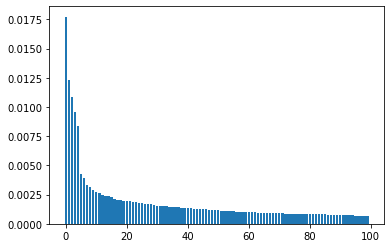

In [20]:
plt.figure()
plt.bar([i for i in range(len(svd.explained_variance_ratio_))], svd.explained_variance_ratio_)
plt.show()

#### Attempt to establish which hashtags are significant for each component of the SVD, and create topics based on these sets

In [21]:
significant = 0.3
print('Correlated: \t Anticorrelated:')
for j, comp in enumerate(svd_comps):
    if any(np.abs(comp)>significant):
        print(str(j) + ': ' + str([feature_names[i] for i in range(len(feature_names))
                                   if comp[i]>significant])+'\t'+str([feature_names[i] 
                                                                      for i in range(len(feature_names)) 
                                                                      if comp[i]<-significant]))

Correlated: 	 Anticorrelated:
0: ['covid19']	[]
1: ['ai', 'cybersecurity', 'fintech']	[]
2: ['cybersecurity']	['ai']
3: ['fintech']	['ai']
4: ['coronavirus']	[]
5: ['iot', 'tech']	[]
6: ['datascience', 'machinelearning']	['tech']
7: ['infosec']	['tech']
8: ['iot', 'security']	['infosec', 'tech']
9: ['blockchain']	[]
10: ['innovation', 'technology']	['tech']
11: ['data']	['innovation']
12: ['iot']	['machinelearning', 'security']
13: ['london']	[]
14: ['innovation', 'security']	['technology']
15: ['brexit']	[]
16: ['privacy']	['security', 'technology']
17: ['data', 'startup']	['payments']
18: ['china', 'covid', 'startup', 'startups']	[]
19: ['china', 'covid']	['startup']
20: ['covid']	['china']
21: ['blacklivesmatter']	[]
22: ['data', 'payments']	['banking']
23: ['bitcoin', 'payments']	['banking']
24: ['bitcoin', 'ransomware']	['blockchain']
25: ['ransomware']	['5g', 'privacy']
26: ['manchester']	[]
27: ['cyber']	[]
28: ['5g']	[]
29: ['startup']	['business', 'startups']
30: ['digital', '

In [22]:
topics = []
themes = []
for comp in svd_comps:
    if any(comp>significant):
        theme_list = [feature_names[i] for i in range(len(feature_names)) if comp[i]>significant]
        themes.extend(theme_list)
        topics.append(theme_list)
themes = list(set(themes))
print(topics)

[['covid19'], ['ai', 'cybersecurity', 'fintech'], ['cybersecurity'], ['fintech'], ['coronavirus'], ['iot', 'tech'], ['datascience', 'machinelearning'], ['infosec'], ['iot', 'security'], ['blockchain'], ['innovation', 'technology'], ['data'], ['iot'], ['london'], ['innovation', 'security'], ['brexit'], ['privacy'], ['data', 'startup'], ['china', 'covid', 'startup', 'startups'], ['china', 'covid'], ['covid'], ['blacklivesmatter'], ['data', 'payments'], ['bitcoin', 'payments'], ['bitcoin', 'ransomware'], ['ransomware'], ['manchester'], ['cyber'], ['5g'], ['startup'], ['digital', 'digitaltransformation'], ['mentalhealth', 'podcast'], ['mentalhealth'], ['artificialintelligence', 'digital'], ['beirut', 'lebanon'], ['belarus'], ['journalism', 'travel'], ['startups'], ['business'], ['apple', 'fcpx', 'video'], ['digitaltransformation'], ['ar', 'vr'], ['property', 'realestate'], ['gdpr', 'lockdown'], ['lockdown'], ['insurtech'], ['jobs'], ['uk'], ['insurtech'], ['openbanking'], ['covid_19'], ['c

In [23]:
translation_matrix = pd.DataFrame()
translation_matrix['hashtags'] = themes
translation_matrix.head()

,hashtags
0,coronavirus
1,cyber
2,video
3,data
4,technology


#### Attempt to get wikipedia pages relating to each hashtag in each topic

In [24]:
tags_to_pages = [] # Create a dict that will map hashtags to wikipedia page titles
tags_to_search = []

print('Hashtag: -> Suggestion: -> Search Result:')
for theme in themes:
    suggestion = wiki.suggest(theme) # This returns a "did you mean"-style alternative to the searching hashtag, this can be useful in identifying an accurate subject match
    if suggestion is not None:
        # If an alternative is suggested, need to decide if the alternative is going to be better than the hashtag
        # Generally, issues in identifying pages correctly arise from a lack of spaces in multi-word hashtags, 
        # So the following 2 lines of code only accept the alternative if it is the same as the hashtag but punctuated with spaces.
        # Suggested alternatives which in any way alter the letters contained in the hashtag are rejected, and the hashtag used instead
        diff = list(difflib.ndiff(theme, suggestion)) 
        if any([item != '+  ' for item in [diff[i] for i in range(len(diff)) if diff[i][0] is not ' ']]):
            search_term = theme
        else:
            search_term = suggestion
    else:
        search_term = theme
    
    search_results = wiki.search(search_term, results=3)
        
    print(theme  + ' -> ' + str(suggestion) + ' -> ' + str(search_results)) # print the top result
    #print('For theme {}, using search term {}.'.format(theme, search_term))
    if len(search_results)>0:
        tags_to_pages.append(search_results[0])
        tags_to_search.append(search_results)
    else:
        tags_to_pages.append(None)
        tags_to_search.append(None)
    
translation_matrix['pages'] = tags_to_pages
translation_matrix['search_results'] = tags_to_search

Hashtag: -> Suggestion: -> Search Result:
coronavirus -> None -> ['Coronavirus', 'COVID-19 pandemic', 'Coronavirus disease 2019']
cyber -> None -> ['Cyber', 'Cyberwarfare', 'Cyber City']
video -> None -> ['Video', 'Video (disambiguation)', 'Video game']
data -> None -> ['Data', 'Data warehouse', 'Data analysis']
technology -> None -> ['Technology', 'TCL Technology', 'Information technology']
uk -> us -> ['United Kingdom', '.uk', 'Sky UK']
podcast -> None -> ['Podcast', 'David Dobrik', 'Lore (podcast)']
iot -> None -> ['Internet of things', 'IOT', 'Narrowband IoT']
cybersecurity -> cyber security -> ['Computer security', 'Cyber-security regulation', 'Cyberattack']
ml -> l -> ['ML', 'Litre', '.ml']
demconvention -> None -> ['Leah D. Daughtry', 'Ady Barkan', '2008 Democratic National Convention']
travel -> None -> ['Travel', '.travel', 'Time travel']
blockchain -> None -> ['Blockchain', 'Privacy and blockchain', 'Fork (blockchain)']
cryptocurrency -> None -> ['Cryptocurrency', 'Cryptocurr

In [25]:
translation_matrix

,hashtags,pages,search_results
0,coronavirus,Coronavirus,"[Coronavirus, COVID-19 pandemic, Coronavirus d..."
1,cyber,Cyber,"[Cyber, Cyberwarfare, Cyber City]"
2,video,Video,"[Video, Video (disambiguation), Video game]"
3,data,Data,"[Data, Data warehouse, Data analysis]"
4,technology,Technology,"[Technology, TCL Technology, Information techn..."
...,...,...,...
91,startup,Startup company,"[Startup company, Startup India, Lean startup]"
92,gdpr,General Data Protection Regulation,"[General Data Protection Regulation, GDPR fine..."
93,ai,Ai,"[Ai, Artificial intelligence, .ai]"
94,insurtech,Ashton Kutcher,"[Ashton Kutcher, Plug and Play Tech Center, Gu..."


In [26]:
pages = []

for topic in topics:
    pages.append([translation_matrix.loc[translation_matrix['hashtags']==theme,'pages'].values[0] for theme in topic])

pages

[['Coronavirus disease 2019'],
 ['Ai', 'Computer security', 'Financial technology'],
 ['Computer security'],
 ['Financial technology'],
 ['Coronavirus'],
 ['Internet of things', 'Tech'],
 ['Data science', 'Machine learning'],
 ['Information security'],
 ['Internet of things', 'Security'],
 ['Blockchain'],
 ['Innovation', 'Technology'],
 ['Data'],
 ['Internet of things'],
 ['London'],
 ['Innovation', 'Security'],
 ['Brexit'],
 ['Privacy'],
 ['Data', 'Startup company'],
 ['China', 'Coronavirus disease 2019', 'Startup company', 'Startup company'],
 ['China', 'Coronavirus disease 2019'],
 ['Coronavirus disease 2019'],
 ['Black Lives Matter'],
 ['Data', 'Payment'],
 ['Bitcoin', 'Payment'],
 ['Bitcoin', 'Ransomware'],
 ['Ransomware'],
 ['Manchester'],
 ['Cyber'],
 ['5G'],
 ['Startup company'],
 ['Digital', 'Digital transformation'],
 ['Mental health', 'Podcast'],
 ['Mental health'],
 ['Artificial intelligence', 'Digital'],
 ['Beirut', 'Lebanon'],
 ['Belarus'],
 ['Journalism', 'Travel'],
 ['S

#### Attempt to bridge overlapping topics

In [27]:
bridged_topics = []

for i, topic in enumerate(pages):
    truth_table = [len(set(theme_list).intersection(topic)) > 0 for theme_list in bridged_topics]
    #print(truth_table)
    if any(truth_table):
        idx = truth_table.index(True)
        merged_topic = list(set(bridged_topics[idx])|set(topic))
        bridged_topics[idx] = merged_topic
        
    else:
        bridged_topics.append(topic)
    

bridged_topics

[['China', 'Coronavirus disease 2019', 'Cloud', 'Startup company'],
 ['Computer security', 'Ai', 'Financial technology'],
 ['Coronavirus'],
 ['Security', 'Tech', 'Internet of things', 'Innovation'],
 ['Data science', 'Machine learning'],
 ['Information security'],
 ['Blockchain'],
 ['Innovation', 'Technology'],
 ['Data', 'Bitcoin', 'Ransomware', 'Startup company', 'Payment'],
 ['London'],
 ['Brexit'],
 ['Privacy'],
 ['Black Lives Matter'],
 ['Manchester'],
 ['Cyber'],
 ['5G'],
 ['Digital transformation', 'Artificial intelligence', 'Digital'],
 ['Mental health', 'Podcast'],
 ['Syria', 'Lebanon', 'Russia', 'Beirut'],
 ['Belarus'],
 ['Journalism', 'Travel'],
 ['Business'],
 ['Environmental, social and corporate governance',
  'Apple',
  'Video',
  'Final Cut Pro X'],
 ['AR', 'VR'],
 ['Real estate', 'Retail', 'Property'],
 ['Leadership',
  'Data breach',
  'General Data Protection Regulation',
  'Lockdown'],
 ['Ashton Kutcher'],
 ['Jobs'],
 ['United Kingdom'],
 ['Openbank'],
 ['Leadership'

In [29]:
other = []
for page in other_theme:
    full_page = wikipedia.page(page).content
    full_page = full_page.split("== See also ==")[0]    #Remove text after "See also"
    page_split = re.split("\. |\.\n",str(full_page))
    
    final_page_split = []    
    for sentence in page_split:
        if len(sentence) >= min_characters_sentence:
            final_page_split.append(sentence)
    final_page_split = final_page_split[0:20]
    other.append(final_page_split) 
    #Append sentences to final other_theme corpus
    #for sentence in final_page_split:
    #    training_corpus = training_corpus.append({'Text':sentence, 'Theme':theme, 'Source':'Wikipedia'}, ignore_index=True)

NameError: name 'other_theme' is not defined

#### Here we need some human input to check the topics etc, perhaps join some more...

In [33]:
topics = [['Coronavirus disease 2019', 'Lockdown'], 
['Artificial intelligence', 'Computer security', 'Financial technology', 'Internet of things', 'Robotics'], 
['Data science', 'Machine learning'],
['Information security'],
['Blockchain', 'Payment', 'Cryptocurrency'],
['Innovation', 'Technology'],
['Data', 'General Data Protection Regulation'],
['Brexit'],
['Privacy'],
['Startup company'],
['China'],
['5G'],
['Digital transformation'],
['Mental health'],
['2020 Beirut explosion', 'Lebanon', 'Beirut'],
['2020 Belarusian protests'],
['Journalism', 'Travel'], 
['Business'],
['Apple Inc.', 'Final Cut Pro X', 'Video'],
['Augmented reality', 'Vertual reality'], 
['Property', 'Real estate'], 
['Architecture', 'Design'],
['Climate change', 'Environmental, social and corporate governance', 'Sustainability'],
['Health care'],
['Cybercrime', 'Ransomeware', 'Malware'],
['Facebook', 'Social media'],
['Other (philosophy)', 'Lexie Brown', 'Baseball broadcasting firsts', 'Rhydlewis', 'Moisés Alou',
    '3rd Weather Squadron', 'Gifty Acheampong', 'Kollines', 'Access Now, Inc. v. Southwest Airlines Co.', 'Australia Made Preference League',
    'Buddhist councils', '2009–10 Olympique de Marseille season', '2013 Tour of Flanders', 'Michael Britten','Frits Potgieter',
    'First Among Sequels', 'Lend Lease Project Management & Construction', 'B. M. Choudary', 'USS La Moure County (LST-1194)', 'John McGinnis', 
    'Valerie Maxfield', 'Lydian language', 'Nathan Alcock', 'İzbırak, Midyat', 'Leonhard Baldner',
    'Julian H. Scaff', "The Boy's Doin' It", "America's Got Talent (season 8)", 'Mass media in the Czech Republic', 'Rear-eject haul truck bodies',
    'Davy Crockett, Indian Scout', 'Métis flag', 'The Second Scroll', 'Institute of Physics and Engineering in Medicine', 'Honda Mobilio',
    'Forced marriage', 'Wetaskiwin', 'Mort Hoppenfeld', 'Saddam Hussein and al-Qaeda link allegations', 'Crane Creek (Melbourne, Florida)']]


Adapted from Martin's code ref:  https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [53]:
min_characters_para = 3   #Min characters in a paragraph (inclusive)
min_characters_word = 3     #Min characters in a word (inclusive)
test_size = 0.2     #Fraction of corpus to keep back for testing

In [ ]:
wiki_pages = topics
themes = ['_'.join(topic) for topic in topics]
del themes[-1]
themes.append('Other')

print(themes)

training_corpus = pd.DataFrame(columns=['Text','Theme','Source'])

for theme,page in zip(themes,wiki_pages):
    all_page = ''
    if isinstance(page, str):
        page=[page,]
    for p in page:
        full_page = wikipedia.page(p).content
        full_page = full_page.split("== See also ==")[0]    #Remove text after "See also"
        all_page += full_page
    
    page_split = str(all_page).split("\n")
    #page_split = re.split("\. |\.\n",str(all_page))
    #print("Number of paragraphs before trimming = "+str(len(page_split)))

    #Only retain paragraphs with at least N characters to retain only proper paragraphs
    final_page_split = []    
    for para in page_split:
        if len(para) >= min_characters_para:
            final_page_split.append(para)

    n_docs_to_proc = len(final_page_split)
    #print("Number of paragraphs after trimming = "+str(n_docs_to_proc))

    #Append paragraphs to final corpus
    for sentence in final_page_split:
        training_corpus = training_corpus.append({'Text':sentence, 'Theme':theme, 'Source':'Wikipedia'}, ignore_index=True)

training_corpus['Theme'].value_counts().plot.barh(figsize=(15,5))
plt.show()

['Coronavirus disease 2019_Lockdown', 'Artificial intelligence_Computer security_Financial technology_Internet of things_Robotics', 'Data science_Machine learning', 'Information security', 'Blockchain_Payment_Cryptocurrency', 'Innovation_Technology', 'Data_General Data Protection Regulation', 'Brexit', 'Privacy', 'Startup company', 'China', '5G', 'Digital transformation', 'Mental health', '2020 Beirut explosion_Lebanon_Beirut', '2020 Belarusian protests', 'Journalism_Travel', 'Business', 'Apple Inc._Final Cut Pro X_Video', 'Augmented reality_Vertual reality', 'Property_Real estate', 'Architecture_Design', 'Climate change_Environmental, social and corporate governance_Sustainability', 'Health care', 'Cybercrime_Ransomeware_Malware', 'Facebook_Social media', 'Other']


# Pre-process training data

In [36]:
# Clean the text - mainly used for processing html

from bs4 import BeautifulSoup

def cleanText(text):
#    text = BeautifulSoup(text, "lxml").text
#    text = re.sub(r'\|\|\|', r' ', text) 
#    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
#    text = text.replace('x', '')
    return text

training_corpus['Text'] = training_corpus['Text'].apply(cleanText)

In [37]:
train, test = train_test_split(training_corpus, test_size=test_size, random_state=42)
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if (len(word) >= min_characters_word) & (word not in stop_words) : tokens.append(word)
#            if (len(word) >= min_characters_word) : tokens.append(word)
    return tokens

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Text']), tags=[r.Theme]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Text']), tags=[r.Theme]), axis=1)


# Apply models

# # Distributed bag of words


In [38]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [39]:
#model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0, workers=cores) #Values from tutorial

model_dbow = Doc2Vec(dm=0, vector_size=500, negative=5, hs=1, min_count=2, sample=0, workers=cores) #My optimised values

model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|████████████████████████████████████████████████████████████████████████| 11885/11885 [00:00<00:00, 760118.07it/s]


In [40]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████████████████| 11885/11885 [00:00<?, ?it/s]


Wall time: 36.3 s


In [41]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [44]:
# Distributed Bag of Words (DBOW) model

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg_dbow = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_dbow.fit(X_train, y_train)
y_pred = logreg_dbow.predict(X_test)
print('logreg_dbow Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('logreg_dbow Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

logreg_dbow Testing accuracy 0.47543741588156124
logreg_dbow Testing F1 score: 0.4691198423744379


C:\Users\elizabeth\anaconda3\envs\python36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Distributed memory


In [45]:
#model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=cores, alpha=0.065, min_alpha=0.065)  #Values from tutorial

model_dmm = Doc2Vec(dm=1, dm_mean=0, vector_size=500, window=10, negative=5, min_count=1, workers=cores, alpha=0.1, min_alpha=0) #My optimised values

model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|████████████████████████████████████████████████████████████████████████████████████| 11885/11885 [00:00<?, ?it/s]


In [46]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|████████████████████████████████████████████████████████████████████████████████████| 11885/11885 [00:00<?, ?it/s]


Wall time: 1min 2s


In [47]:
# Distributed Memory (DM) model

y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg_dmm = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_dmm.fit(X_train, y_train)
y_pred = logreg_dmm.predict(X_test)
print('logreg_dmm Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('logreg_dmm Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

logreg_dmm Testing accuracy 0.4882234185733513
logreg_dmm Testing F1 score: 0.48921700905427407


C:\Users\elizabeth\anaconda3\envs\python36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Combined model pairing

In [48]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
model_new = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [49]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [50]:
# Model Pairing method

y_train, X_train = get_vectors(model_new, train_tagged)
y_test, X_test = get_vectors(model_new, test_tagged)
logreg_new = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_new.fit(X_train, y_train)
y_pred = logreg_new.predict(X_test)
print('logreg_new Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('logreg_new Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

logreg_new Testing accuracy 0.6039703903095559
logreg_new Testing F1 score: 0.6078530214381682


C:\Users\elizabeth\anaconda3\envs\python36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [51]:
#Free up memory (not necessary for our small training sample)
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# Apply to tweets

In [171]:
def get_vectors_apply(model, docs_to_classify):
    sents = docs_to_classify.values
    regressors = [model.infer_vector(doc.words, steps=20) for doc in sents]
    return regressors

In [173]:
def clean_text(text):
    text = re.sub(r"http\S+", "", str(text)) #remove urls
    text = re.sub(r'\S+\.com\S+','',str(text)) #remove urls
    text = re.sub(r'\@\w+','',str(text)) #remove mentions
    text =re.sub(r'\#','',str(text)) #remove hashtags
    text = re.findall(r'[A-Za-z]+',str(text))
    text = ' '.join(text) 
    return text

In [177]:
src_dir = r'C:\Users\elizabeth\Documents\cleaned tweets\cyber friends tweets'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
logreg_model = logreg_new
model = model_new

with tqdm(total=len(files), desc='Files') as pbar:
    i=0
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df = df[df.text != '']
        df['clean_tweet'] = df['text'].apply(lambda x: clean_text(x))
        test_tagged = df.apply(
            lambda r: TaggedDocument(words=tokenize_text(r['clean_tweet']), tags=[r.screen_name]), axis=1)
        X_test = get_vectors_apply(model, test_tagged)
        df['y_pred'] = logreg_model.predict(X_test)
        y_pred_score = logreg_model.predict_proba(X_test)
        df2 = pd.DataFrame(y_pred_score)
        df2.columns=logreg_model.classes_
        df2['score'] = df2.max(axis=1)
        df['score'] = df2['score']
        df3 = df[['tweet_id','screen_name', 'text', 'y_pred', 'score']].copy()
        df4 = pd.concat([df3, df2], axis=1)
        df3.to_csv('topic_modelled_'+str(i)+'.csv', index=False)
        df4.to_csv('all_topics_modelled_'+str(i)+'.csv', index=False)
        print(df4.head())
        pbar.update(1)
        i = i+1


Files:   0%|                                                                                    | 0/40 [03:30<?, ?it/s]


KeyboardInterrupt: 

# How are journalists interests are spread?

first we need to drop the row where the classification has been less than 0.5, then we can pool over user_name

In [ ]:
src_dir = r'C:\Users\elizabeth\Documents\Python Scripts\all_topics_modelled'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
ls = list(logreg_dmm.classes_)
ls.insert(0, 'screen_name')
df_totalled_topics = pd.DataFrame(columns=ls)

df_totalled_topics

In [ ]:
with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df1 = df[~(df['score'] <= 0.5)] 
        df2 = df1.groupby('screen_name')['5g', 'IOT', 'ai', 'analyticsinvestment',
                                        'apple', 'banking', 'beirut', 'belarus', 'blacklivesmatter',
                                        'brexit', 'business', 'china', 'climatechange', 'cloud',
                                        'covid19', 'crypto', 'cryptocurrency', 'cybersecurity', 'data',
                                        'datascience', 'demconvention', 'economy', 'esg', 'fintech', 'gdpr',
                                        'healthcare', 'hongkong', 'infosec', 'insurance', 'iran', 'jobs', 'leadership',
                                        'machinelearning', 'mentalhealth', 'paymentsprivacy', 'phishing', 'podcast',
                                        'property', 'regtech', 'retail', 'robotics', 'socialmedia', 'startup',
                                        'sustainability', 'syria', 'vr', 'webinar', 'womenintech'].sum()
        df_totalled_topics = pd.concat([df_totalled_topics, df2])
        pbar.update(1)
df_totalled_topics.head()


In [ ]:
df_totalled_topics['total'] = df_totalled_topics.sum(axis = 1)

In [ ]:
df3 = df_totalled_topics[['5g', 'IOT', 'ai', 'analyticsinvestment',
                        'apple', 'banking', 'beirut', 'belarus', 'blacklivesmatter',
                        'brexit', 'business', 'china', 'climatechange', 'cloud',
                        'covid19', 'crypto', 'cryptocurrency', 'cybersecurity', 'data',
                        'datascience', 'demconvention', 'economy', 'esg', 'fintech', 'gdpr',
                        'healthcare', 'hongkong', 'infosec', 'insurance', 'iran', 'jobs', 'leadership',
                        'machinelearning', 'mentalhealth', 'paymentsprivacy', 'phishing', 'podcast',
                        'property', 'regtech', 'retail', 'robotics', 'socialmedia', 'startup',
                        'sustainability', 'syria', 'vr', 'webinar', 'womenintech', 'total']].div(df_totalled_topics.total, axis=0)
df3 = df3.drop(['total'], axis=1)
df3.reset_index(inplace=True)

In [ ]:
df3 = df3.rename(columns={'index': 'user_name'})
df3

In [ ]:
df3.to_csv('user_name_topics_summed.csv', index=False)


In [ ]:
df4 = df3.set_index('user_name')

In [ ]:


x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df4.columns)
row1 = df4.iloc[0]
row1.plot(kind='bar',title='Oxchich', color='r',stacked=False, figsize=(15,5))





In [ ]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df2.columns)
row1 = df2.iloc[1]
row1.plot(kind='bar',title='_benkatz', color='r',stacked=False, figsize=(15,5))


In [ ]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df4.columns)
row1 = df4.iloc[0]
row1.plot(kind='bar',title='_john_handel', color='r',stacked=False, figsize=(15,5))

# Wordclouds for a sense check 

In [ ]:
!pip install wordcloud


In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [ ]:
def wordcloud_plot(text):
    wordcloud = WordCloud(collocations=False, 
                          width = 1000, 
                          height = 700, 
                          background_color ='white', 
                          min_font_size = 10).generate(text)
    
    plt.figure(figsize = (8,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [ ]:
src_dir = r'C:\Users\elizabeth\Documents\Python Scripts\cyber_topic_modelled'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
with tqdm(total=len(files), desc='Files') as pbar:
    for file in files[:5]:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df1 = df.groupby(['y_pred'])[['text']].sum()
        pbar.update(1)
        



In [ ]:
df1.head(3).style.set_properties(subset=['text'], **{'width':'1000px'})

In [ ]:
wordcloud_plot(df1['text'][0])


In [ ]:
wordcloud_plot(df1['text'][1])

In [ ]:
wordcloud_plot(df1['text'][2])